In [19]:
#
# STD IMPORTS
#
import json
import pickle
import sys, os
import numpy as np
import pandas as pd

from math import radians, cos, sin, asin, sqrt
from collections import defaultdict
from collections import OrderedDict

from flatten_json import flatten
from flatten_json import flatten_json

# NLP Lib
import nltk
from nltk.corpus import stopwords

# Sklearn 
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Computing ditance from longitude and latitude
def distance(lat1, lat2, lon1, lon2):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    
    c = 2 * asin(sqrt(a))
    r = 6371
    return (c*r)

In [4]:
# Get all businesses from dataset
businesses = []
for line in open('../yelp_dataset/yelp_academic_dataset_business.json', 'r'):
    businesses.append(json.loads(line))
reviews = []
for line in open('../yelp_dataset/yelp_academic_dataset_review.json', 'r'):
    reviews.append(json.loads(line))

In [5]:
# Extract all the Toronto restaurants
toronto = []
for business in businesses:
    if business['city'] == 'Toronto':
        toronto.append(business)

In [6]:
# For chosen city Toronto
toronto_flat = []
for business in toronto:
    toronto_flat.append(flatten(business))
df = pd.DataFrame([flatten_json(x) for x in toronto])

In [7]:
# We can see that many columns have NaN
filterDF = df[df.columns[df.isnull().mean() < 0.35]]
filterDF.columns

Index(['address', 'attributes_BusinessParking',
       'attributes_RestaurantsPriceRange2', 'business_id', 'categories',
       'city', 'hours_Friday', 'hours_Monday', 'hours_Saturday',
       'hours_Thursday', 'hours_Tuesday', 'hours_Wednesday', 'is_open',
       'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars',
       'state'],
      dtype='object')

In [8]:
# Filter features
dataDF = pd.concat([df['business_id'], 
                    df['latitude'], 
                    df['longitude'],
                    df['stars'],
                    df['is_open'],], axis='columns')

dataDF.head()

business_id   latitude  longitude  review_count  stars  is_open
0  EosRKXIGeSWFYWwpkbhNnA  43.624539 -79.529108            16    3.0        1
1  1wWneWD_E1pBIyVpdHMaQg  43.656542 -79.381308             9    4.0        1
2  007Dg4ESDVacWcC4Vq704Q  43.603232 -79.538424             8    4.0        0
3  rVBPQdeayMYht4Uv_FOLHg  43.633291 -79.531768            13    3.0        0
4  9JCjKd6eFXsAMVwouTh_4Q  43.727189 -79.293008             7    3.5        1

In [16]:
#
# Load sentiment analysis model
#

# CLEAN BOW
import string

def clean_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    cleaned_text = [word for word in nopunc.split() 
                    if word.lower() not in stopwords.words('english')]
    return cleaned_text

# LOAD MODELS
bow_transformer = pickle.load(open('../sentiment-analysis/bow_transformer.sav', 'rb'))
nb = pickle.load(open('../sentiment-analysis/NBModel.sav', 'rb'))

In [20]:
#
# Singular review prediction
#

def predict_review(review):
    review_transformed = bow_transformer.transform([review])
    pred = nb.predict(review_transformed)[0]
    
    return 'positive' if pred==5 else 'negative'

In [27]:
# Sample review prediction
# change index to change review
print(reviews[2]['text'])
print('MODEL PREDICTION: ', predict_review(reviews[2]['text']))

I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and house fries are my standbys. The fries are sometimes good and sometimes great, and the spicy dipping sauce they come with is to die for. The beer list is amazing and the cocktails are great. The prices are mid-level, so it's not a cheap dive you can go to every week, but rather a treat when you do. Try it out. You won't be disappointed!
MODEL PREDICTION:  positive


In [65]:
# Create list of business_ids
toronto_bid = []
for business in toronto:
    toronto_bid.append(business['business_id'])

dataDF['pos_reviews'] = 0    
dataDF['review_count'] = 0

In [68]:
for review in reviews:
    if review['business_id'] in toronto_bid:
        idx = dataDF.index[dataDF['business_id'] == review['business_id']][0]
        dataDF.at[idx, 'review_count'] = \
            dataDF.iloc[idx]['review_count']+1
        if predict_review(review['text']) == 'positive':
            dataDF.at[idx, 'pos_reviews'] = \
                dataDF.iloc[idx]['pos_reviews']+1


In [69]:
dataDF.head()

business_id   latitude  longitude  review_count  stars  is_open  \
0  EosRKXIGeSWFYWwpkbhNnA  43.624539 -79.529108            17    3.0        1   
1  1wWneWD_E1pBIyVpdHMaQg  43.656542 -79.381308             9    4.0        1   
2  007Dg4ESDVacWcC4Vq704Q  43.603232 -79.538424             9    4.0        0   
3  rVBPQdeayMYht4Uv_FOLHg  43.633291 -79.531768            13    3.0        0   
4  9JCjKd6eFXsAMVwouTh_4Q  43.727189 -79.293008             7    3.5        1   

   pos_reviews  
0           12  
1            8  
2            7  
3           11  
4            4

In [95]:
for business in toronto:
    print(business['categories'])
    print()
len(toronto)

Martial Arts, Gyms, Fitness & Instruction, Active Life

Shopping, Shoe Stores, Fashion

Shopping, Food, Organic Stores, Specialty Food, Health Markets, Food Delivery Services, Grocery, Farmers Market

Restaurants, Burgers, Food

Cosmetics & Beauty Supply, Shopping, Beauty & Spas

Vietnamese, Restaurants

Event Planning & Services, Photo Booth Rentals, Venues & Event Spaces, DJs, Party & Event Planning, Party Supplies

Health & Medical, Massage Therapy, Eyelash Service, Waxing, Beauty & Spas, Hair Removal

Fitness & Instruction, Martial Arts, Active Life

Shopping, Computers

Food, Grocery

Bagels, Donuts, Food, Cafes, Coffee & Tea, Restaurants, Bakeries

Home Services, Shopping, IT Services & Computer Repair, Internet Cafes, Food, Local Services, Computers, Internet Service Providers, Professional Services

Dermatologists, Doctors, Health & Medical

Fast Food, Restaurants, Chicken Shop

Coffee & Tea, Restaurants, Sandwiches, Food

Food, Beer, Wine & Spirits

Steakhouses, Restaurants, N


Active Life, Escape Games

Restaurants, Food, Gluten-Free, International, German, Tapas/Small Plates, Breakfast & Brunch, Cafes, Desserts, Bars, Nightlife, Beer Bar

Cafes, Restaurants, Salad, Sandwiches

Bars, Canadian (New), Nightlife, Restaurants, Sports Bars, Dive Bars

Local Services, Self Storage, Movers, Home Services

Hair Salons, Beauty & Spas

Restaurants, Latin American

Interior Design, Home Services

Convenience Stores, Restaurants, American (Traditional), Food

Local Services, Truck Rental, Self Storage, Automotive

Pharmacy, Health & Medical, Shopping, Drugstores

Shopping, Drugstores

Restaurants, Chinese, Barbeque

Indian, Restaurants, Sri Lankan

Mediterranean, Event Planning & Services, Caterers, Restaurants, Middle Eastern

Books, Mags, Music & Video, Bookstores, Videos & Video Game Rental, Shopping, Music & DVDs

Local Services, Appraisal Services, Shopping, Jewelry, Pawn Shops

Laundry Services, Local Services, Dry Cleaning, Dry Cleaning & Laundry

Restaurants, M

Japanese, Sushi Bars, Restaurants, Tapas Bars, Noodles

Restaurants, Italian

Local Services, Laundry Services, Dry Cleaning & Laundry

Restaurants, Italian

Restaurants, Pizza

Optometrists, Health & Medical

Grocery, Food

Restaurants, Food, Butcher, Barbeque, Bars, Nightlife, Burgers

Chinese, Restaurants, Korean

Restaurants, Bars, Steakhouses, Nightlife, Seafood

Food, Specialty Food, Seafood Markets

Nightlife, Bars, Dance Clubs

Food, American (New), Restaurants, Canadian (New)

Office Cleaning, Home Services, Home Cleaning, Professional Services

Appliances & Repair, Shopping, Wholesale Stores, Local Services

Coffee & Tea, Restaurants, Breakfast & Brunch, Bagels, Food

Beauty & Spas, Hair Salons, Barbers, Hair Removal

Seafood, Desserts, Food, Filipino, Restaurants

Fast Food, Restaurants, Burgers

Italian, Restaurants

Restaurants, Food, Bakeries, Delis

Nail Salons, Beauty & Spas

Restaurants, Food, Cafes, Coffee & Tea

Shopping, Knitting Supplies, Arts & Crafts

Shopping, P

Party & Event Planning, Event Planning & Services, Venues & Event Spaces, Arts & Entertainment

Coffee & Tea, Breakfast & Brunch, Restaurants, Food, Jewelry, Creperies, Shopping

Cafes, Japanese, Breakfast & Brunch, Restaurants

Toy Stores, Shopping

Bars, Nightlife, American (New), Canadian (New), Restaurants

Food, Restaurants, Indian

Restaurants, Canadian (New), American (New)

Hakka, Restaurants, Chinese

Financial Services, Banks & Credit Unions

Sports Bars, Cocktail Bars, Tapas Bars, Restaurants, Lounges, Asian Fusion, Nightlife, Bars

Airports, Car Rental, Hotels & Travel

Korean, Restaurants

Dry Cleaning & Laundry, Local Services, Laundry Services

Cantonese, Restaurants, Chinese, Portuguese

Health Markets, Food, Shopping, Specialty Food, Vitamins & Supplements

Food, Beer, Wine & Spirits

Hair Salons, Barbers, Beauty & Spas

Food, Bagels

Shopping, Videos & Video Game Rental, Books, Mags, Music & Video

Sports Bars, Restaurants, Bars, Nightlife

Hotels & Travel, Bed & Brea


Beer, Wine & Spirits, Food

Lingerie, Fashion, Maternity Wear, Shopping, Baby Gear & Furniture

Mexican, Restaurants

Chinese, Szechuan, Noodles, Restaurants

Restaurants, Canadian (New), Bars, Nightlife, Pubs, Arts & Entertainment, Music Venues

Korean, Restaurants, Japanese, Asian Fusion

Restaurants, Pizza, Steakhouses, Sandwiches, Italian

Ice Cream & Frozen Yogurt, Food, Wedding Planning, Event Planning & Services, Caterers, Party & Event Planning

Cafes, Restaurants

Shopping, Sporting Goods, Bikes

Beauty & Spas, Shopping, Cosmetics & Beauty Supply

Sandwiches, American (New), Restaurants

Restaurants, Bistros

Shopping, Printing Services, Professional Services, Signmaking, Shipping Centers, Couriers & Delivery Services, Office Equipment, Local Services

Bars, Wine Bars, Nightlife, Bakeries, Restaurants, Vegan, Organic Stores, Food, Beer, Wine & Spirits, Coffee & Tea, Specialty Food

Shopping, Department Stores, Fashion

Food, Coffee & Tea, Coffee Roasteries

Water Purification

South African, Pakistani, African, Restaurants, Portuguese, Halal, Chicken Shop

Coffee & Tea, Food, Bubble Tea, Bakeries

Currency Exchange, Financial Services

Seafood, Sushi Bars, Korean, Restaurants, Japanese

Musical Instrument Services, Shipping Centers, Movers, Local Services, Piano Services, Self Storage, Couriers & Delivery Services, Home Services

Skin Care, Tanning, Hair Removal, Beauty & Spas, Waxing

Barbeque, Restaurants, Sandwiches, American (Traditional)

Pet Training, Pet Services, Pets

Financial Services, Insurance

Coffee & Tea, Juice Bars & Smoothies, Restaurants, Bubble Tea, Tea Rooms, Taiwanese, Food

Active Life, Fitness & Instruction, Dance Studios, Arts & Entertainment, Dance Schools, Performing Arts, Education, Specialty Schools

Restaurants, Burgers

Health & Medical, Massage Therapy, Beauty & Spas, Massage

Tapas/Small Plates, Restaurants, Nightlife, Bars

Restaurants, Portuguese, Seafood

Grocery, Food

Restaurants, Barbeque

Italian, Restaurants

Taiwanes

Coffee & Tea, Food

Food, Bakeries, Coffee & Tea

Kebab, Persian/Iranian, Restaurants

Public Services & Government, Post Offices, Shopping, Drugstores

Breakfast & Brunch, Canadian (New), Fast Food, Sandwiches, Restaurants, Vegetarian

Shopping, Fashion, Lingerie

Florists, Cards & Stationery, Arts & Crafts, Flowers & Gifts, Shopping, Event Planning & Services

Active Life, Swimming Pools

Bars, Restaurants, Breakfast & Brunch, Nightlife, Pubs

Automotive, Auto Repair

Health & Medical, Cosmetic Dentists, Dentists, General Dentistry, Endodontists, Pediatric Dentists

Men's Clothing, Shopping, Women's Clothing, Accessories, Fashion

Caribbean, Vegan, Restaurants

Education, Elementary Schools, Middle Schools & High Schools

Beauty & Spas, Makeup Artists, Day Spas, Health & Medical, Medical Spas

Real Estate, Home Services, Shopping Centers, Property Management, Shopping

Dry Cleaning, Dry Cleaning & Laundry, Laundry Services, Local Services

Department Stores, Women's Clothing, Men's C

Restaurants, Burgers, Fast Food

Ethnic Food, Imported Food, Restaurants, Convenience Stores, Specialty Food, Ethiopian, Food

Medical Spas, Skin Care, Beauty & Spas, Health & Medical

Korean, Restaurants

Hair Salons, Beauty & Spas

Restaurants, Chinese

Nail Salons, Beauty & Spas

Turkish, Restaurants

Seafood, Restaurants

Pediatricians, Health & Medical, Doctors

Home Services, Lawyers, Real Estate Services, Professional Services, Real Estate, Real Estate Law

Carpeting, Home Services, Shopping, Flooring, Carpet Installation

Pizza, Restaurants

Nightlife, Bars, Restaurants, American (New), Canadian (New)

Restaurants, Chinese

Beauty & Spas, Makeup Artists, Hair Salons, Hair Extensions

Restaurants, Pizza

Convenience Stores, Food

Shopping, Fashion, Women's Clothing, Used, Vintage & Consignment

Cafes, Restaurants

Hotels & Travel, Travel Agents, Travel Services

Caribbean, Fast Food, Comfort Food, Restaurants

Beauty & Spas, Hair Salons

Fashion, Shoe Stores, Shopping, Sporting 

Beer, Wine & Spirits, Nightlife, Bars, Restaurants, Food, Gastropubs, Irish

Event Planning & Services, Mediterranean, Restaurants, Greek, Caterers

Shopping, Fashion, Leather Goods

Apartments, Home Services, Real Estate, Hotels & Travel, Local Services, Vacation Rentals

Hotels & Travel, Hostels

Hair Salons, Cosmetics & Beauty Supply, Hair Stylists, Shopping, Beauty & Spas

Health & Medical, Massage Therapy, Chiropractors, Physical Therapy

Cajun/Creole, Restaurants

Trainers, Fitness & Instruction, Gyms, Active Life

Beauty & Spas, Hair Salons

Japanese, Sushi Bars, Restaurants

Restaurants, Pizza

Restaurants, Chinese

Specialty Food, Ethnic Food, Food, Grocery

Restaurants, Korean

Sewing & Alterations, Laundry Services, Dry Cleaning & Laundry, Local Services

Restaurants, Indian

Pizza, Restaurants

Cards & Stationery, Event Planning & Services, Gift Shops, Flowers & Gifts, Arts & Crafts, Shopping

Chinese, Dim Sum, Restaurants

Vegetarian, Restaurants, Indian, Fast Food

Real E


Coffee & Tea, Food, Bakeries

Noodles, Food Stands, Vietnamese, Sandwiches, Restaurants

Comfort Food, Nightlife, Restaurants, Chicken Wings, Lounges, Pubs, Dive Bars, Bars, American (Traditional), Cocktail Bars

Beauty & Spas, Day Spas, Massage

Bars, Pubs, Nightlife

Shopping, Mobile Phones

Music Venues, Arts & Entertainment, Bars, Karaoke, Nightlife, Dive Bars

American (Traditional), Breakfast & Brunch, American (New), Restaurants

Restaurants, Thai

Massage, Eyelash Service, Beauty & Spas, Reflexology, Acupuncture, Day Spas, Massage Therapy, Health & Medical

Blow Dry/Out Services, Beauty & Spas, Hair Salons

Hair Removal, Threading Services, Beauty & Spas, Waxing, Skin Care

Food, Tea Rooms, Restaurants, Coffee & Tea, Taiwanese

Beauty & Spas, Hair Salons, Barbers

Health & Medical, Parenting Classes, Specialty Schools, Education

Nightlife, Bars, Cocktail Bars, Cafes, Restaurants

Specialty Food, Food, Grocery

Arabian, Restaurants, Middle Eastern

Graphic Design, Local Servic

Active Life, Fitness & Instruction, Dance Studios

Butcher, Middle Eastern, Restaurants, Food

Nightlife, Bars, Restaurants

Health & Medical, Active Life, Beauty & Spas, Chiropractors, Pilates, Acupuncture, Fitness & Instruction, Massage

Automotive, Car Dealers

Bars, Pubs, Nightlife

Specialty Schools, Education, Cooking Schools

Food, Beer, Wine & Spirits

Sushi Bars, Restaurants, Japanese

Shopping, Bikes, Sporting Goods

Tattoo, Beauty & Spas

Food, Coffee & Tea

Ice Cream & Frozen Yogurt, Specialty Food, Desserts, Food

Beauty & Spas, Event Planning & Services, Fashion, Skin Care, Arts & Crafts, Cards & Stationery, Accessories, Shopping, Flowers & Gifts

American (New), Restaurants, Canadian (New)

Coffee & Tea, Bakeries, Food, Desserts, Bubble Tea

Gyms, Fitness & Instruction, Trainers, Sports Clubs, Active Life

Wedding Planning, Party & Event Planning, Event Planning & Services, Hotels, Venues & Event Spaces, Hotels & Travel

Event Planning & Services, Lounges, Venues & Event

Education, Colleges & Universities, Beauty & Spas, Massage

Coffee & Tea, Food

Physical Therapy, Health & Medical, Chiropractors, Massage Therapy

Active Life, Skin Care, Beauty & Spas, Waxing, Day Spas, Hair Removal

Real Estate, Fashion, Home Services, Men's Clothing, Shopping, Home Staging, Women's Clothing

Hobby Shops, Comic Books, Books, Mags, Music & Video, Shopping, Bookstores

Coffee & Tea, Food

Beauty & Spas, Hair Salons

Restaurants, Pizza

Fashion, Shopping, Lingerie, Swimwear

Food, Coffee & Tea

Food, Restaurants, Sandwiches, Soup, Coffee & Tea

Sushi Bars, Japanese, Restaurants

Fashion, Shopping

Yoga, Fitness & Instruction, Active Life, Pilates

Beauty & Spas, Hair Salons

Laser Hair Removal, Health & Medical, Medical Spas, Acne Treatment, Hair Removal, Beauty & Spas, Day Spas

Sushi Bars, Restaurants, Japanese

Canadian (New), American (New), Restaurants

Shopping, Drugstores

Indian, Restaurants

Juice Bars & Smoothies, Food, Sandwiches, Restaurants

Sporting Goods

20366

In [101]:
# Use regex to filter out non restaurants
import re
import string

not_toronto_restaurants = []
for business in toronto:
    if type(business['categories']) != str:
        continue
    if re.search(r"(Restaurant|Food|Bagel|Coffee|\
                    Eat|Cafe|Burgers|Donuts|Tea|\
                    Baker|Sandwich|Chicken|Beer|Wine|\
                    Bar|Wings|Hot Pot|Ice Cream|\
                    Poke|Korean|Italian|Indian|Asian|\
                    Dessert|Pizza|Waffle|Spanish|French|\
                    Barbeque|Vegan|Vegetarian|Sushi|Mexican|\
                    Noodles|Breakfast|Lunch|Dinner|Dim Sum|\
                    Japanese|Vietnamese|Taiwanese|Food Truck|\
                    Smoothies|Mongolian|American|Canadian|\
                    Kosher|Halal|Seafood|Creperie|Greek|Thai)", business['categories']) is not None:
        continue
    else:
        not_toronto_restaurants.append(business['business_id'])

9231

In [103]:
# Remove anything that isn't a restaurant
for business_id in not_toronto_restaurants:
    idx = dataDF.index[dataDF['business_id'] == business_id]
    dataDF.drop(idx, inplace=True)

In [108]:
# Reset all indices
dataDF.reset_index(drop=True)

business_id   latitude  longitude  review_count  stars  \
0      007Dg4ESDVacWcC4Vq704Q  43.603232 -79.538424             9    4.0   
1      rVBPQdeayMYht4Uv_FOLHg  43.633291 -79.531768            13    3.0   
2      0QjROMVW9ACKjhSEfHqNCQ  43.666376 -79.348773           116    4.0   
3      GtQPbazps0jt7_cJghfmsA  43.670936 -79.384643            42    2.5   
4      8k62wYhDVq1-652YbJi5eg  43.649859 -79.382060             8    3.0   
5      PYLv9n0y8MimzTK2zCBoFw  43.664707 -79.413939             4    3.0   
6      0DnQh8SE8BSnvJltGCCiWg  43.765279 -79.326248            11    3.0   
7      NLaK58WvlNQdUunSIkt-jA  43.685608 -79.313936            24    4.5   
8      OIKp-6ObAd-yW-32U3c22Q  43.664927 -79.411553             9    4.0   
9      cicPsia8Wj-DNRkmLbD_xg  43.705843 -79.397841           100    3.5   
10     0nqQIM2PvOcTX6v0L537_Q  43.680413 -79.290279            19    4.0   
11     tdtU7pk3swBuGYBQgyLgTw  43.655928 -79.409528             7    4.0   
12     xVXyrTWbG8U3szze-aA7eg  43.690144 -79.571658            35    2.0   
13     YHE1PS0mhFbwKJm8iJpcuQ  43.650533 -79.415209            23    3.5   
14     r3jpH6ZuCQY3o1yBuJ67PQ  43.652251 -79.397642            17    3.0   
15     M0CBCEY1UFX0JCRzKZ9ujw  43.725989 -79.289429            10    3.5   
16     TKKX9bllRBMzp0NYr441PQ  43.657621 -79.400885            51    4.0   
17     d9A5lhFHOBvEw-BxSYnWOA  43.663746 -79.416452             4    4.0   
18     Ntolf_VZiTOpVTjAyaMNnA  43.642095 -79.380851             5    4.0   
19     yG2PdMFn6y3QDw4Uq4b5lg  43.761612 -79.409221            78    3.0   
20     u0syM4rt_zDpswP47g0pGQ  43.641832 -79.411263            11    3.5   
21     37kk0IW6jL7ZlxZF6k2QBg  43.641948 -79.406580           120    4.0   
22     y1Er-SodAde9QZIcgFf45g  43.734367 -79.404422             8    2.0   
23     0rMFhLzeq3Z2OaJ62MQXlw  43.686247 -79.393561            14    4.0   
24     dfqLhdQY9e6EiXMk9t-8WQ  43.666508 -79.497870             3    4.5   
25     rOyzxtWGekcMBc4aNinZjg  43.700347 -79.429634            14    3.0   
26     VUADGMPLJoWqhHb1G4LIcA  43.649166 -79.422498            71    5.0   
27     LRRhbtaohbXGMdaJ1yZjbQ  43.646357 -79.390044            38    4.0   
28     oYCx5gO4KkkgYPnglSkk5g  43.681282 -79.428728            20    3.0   
29     5JW08_RL9K60Ubo8-8lyVg  43.658741 -79.422842            73    4.0   
...                       ...        ...        ...           ...    ...   
11105  YrFBrZSOPqR37lQrUG2gGw  43.665620 -79.350612             8    2.0   
11106  Pthcdg09sHQ9M9Tj5P9gfQ  43.648248 -79.373359           331    3.5   
11107  SN0-O-CuIsyZf3LGZVEUAw  43.731850 -79.403557            16    4.0   
11108  _S58fmMsy4v2odxzAhMzTA  43.767107 -79.227681             5    3.0   
11109  IE1lzZvdD9UnGeB1kXjuOQ  43.665523 -79.410272           157    3.5   
11110  wmTc6sSJxPwSj4NyvgffAw  43.663055 -79.331607             7    4.0   
11111  dUYJ5wXR8U-eUD-RY8EhKw  43.782745 -79.490548            20    2.5   
11112  undz-LtXIta312RP_DqmFQ  43.649047 -79.374216             4    4.0   
11113  9Hkl537QmiS37UyH0zv5QQ  43.640956 -79.402172            31    4.0   
11114  cY70RdP5w6gxRhY-wZ681A  43.760911 -79.224161            17    2.5   
11115  LrrJW6ejsVL7hADfFy87Eg  43.770441 -79.412986            30    3.5   
11116  r6bvqwhWy73SgyK_w8Y5Lg  43.772208 -79.321208            24    3.5   
11117  AsvquIiLiKuXnGq2Br0ojA  43.669798 -79.391163             5    4.5   
11118  5ebXuHpZRNdalRULfnfnpw  43.663085 -79.397746             7    2.0   
11119  Cesnh6fIsAUO8D4jfGhOIw  43.650352 -79.383795            22    3.5   
11120  4itFChF4I-d2Mkleyh-tvA  43.656658 -79.383611             5    5.0   
11121  lkq6i2x3vUsR7ZNrIFqoIw  43.646814 -79.513834            32    3.5   
11122  uBmJygqjv9YuhwGD5WjDww  43.704174 -79.388361            65    3.5   
11123  w1VXjywWKPQUCcX7vd32Pw  43.652612 -79.406956            23    4.5   
11124  9F_3PA1QBQ3aGI2RW2zMtw  43.647430 -79.386774            22    2.0   
11125  6R4GzPhlFS1n_xCO7U7Gcw  43.649680 -79.429522            52 

In [109]:
dataDF.to_csv('Yelp_Filtered_SA_Dataset.csv')

### Visualizing Toronto

In [116]:
# Select "clean" features
dfsel = pd.read_csv('Yelp_Filtered_SA_Dataset.csv')
dfsel['label'] = dfsel['stars'].apply(lambda x: 1 if x > 3 else 0)
dfsel.head()

Unnamed: 0             business_id   latitude  longitude  review_count  \
0           2  007Dg4ESDVacWcC4Vq704Q  43.603232 -79.538424             9   
1           3  rVBPQdeayMYht4Uv_FOLHg  43.633291 -79.531768            13   
2           5  0QjROMVW9ACKjhSEfHqNCQ  43.666376 -79.348773           116   
3          10  GtQPbazps0jt7_cJghfmsA  43.670936 -79.384643            42   
4          11  8k62wYhDVq1-652YbJi5eg  43.649859 -79.382060             8   

   stars  is_open  pos_reviews  label  
0    4.0        0            7      1  
1    3.0        0           11      0  
2    4.0        1          109      1  
3    2.5        1           26      0  
4    3.0        1            7      0

In [121]:
dfplot = pd.concat([dfsel.loc[:,'latitude'],
                    dfsel.loc[:,'longitude'],
                    dfsel.loc[:,'label']],axis='columns')
dfplot.head()

latitude  longitude  label
0  43.603232 -79.538424      1
1  43.633291 -79.531768      0
2  43.666376 -79.348773      1
3  43.670936 -79.384643      0
4  43.649859 -79.382060      0

In [122]:
x = dfplot['latitude'].to_numpy()
y = dfplot['longitude'].to_numpy()

labels = dfplot['label'].to_numpy()
x = x.astype('float')
y = y.astype('float')

In [123]:
# Graphing lib
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

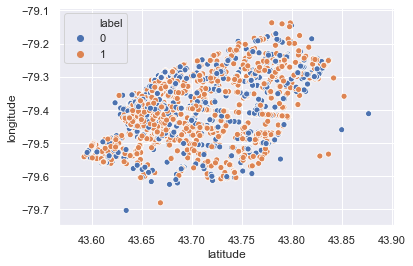

In [131]:
ax = sns.scatterplot(x='latitude',y='longitude', hue='label', data=dfplot)
#ax.set(xlim=(43.7,43.75))
#ax.set(ylim=(-79.5,-79.4))

In [130]:
#fig = ax.get_figure()
#fig.savefig('TorontoZoomed.png')